In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
from sklearn.cluster import DBSCAN, KMeans
        
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae

import tensorflow as tf
import tensorflow_addons as tfa

/kaggle/input/playground-series-s3e8/sample_submission.csv
/kaggle/input/playground-series-s3e8/train.csv
/kaggle/input/playground-series-s3e8/test.csv
/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv
/kaggle/input/gemstone-price-prediction/Data Dictionary.xlsx


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e8/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e8/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s3e8/sample_submission.csv")
original = pd.read_csv("/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv")

In [3]:
!pip install openpyxl
!pip install xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.4 MB/s eta 0:00:00


In [4]:
dictionary = pd.read_excel('/kaggle/input/gemstone-price-prediction/Data Dictionary.xlsx', index_col=0)

In [5]:
dictionary.head()

,Description
Variable Name,
Carat,Carat weight of the cubic zirconia.
Cut,Describe the cut quality of the cubic zirconi...
Color,Colour of the cubic zirconia.With D being the...
Clarity,cubic zirconia Clarity refers to the absence ...
Depth,"The Height of a cubic zirconia, measured from..."


In [6]:
train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [7]:
original.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [8]:
cols = train.columns.tolist()
cols.remove('id')
cols

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price']

In [9]:
train_df = pd.concat([train.copy(),original.copy()],ignore_index=True)

In [10]:
train_df = train_df[~train_df.duplicated(subset=cols)]
train_df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price,Unnamed: 0
0,0.0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619,NaN
1,1.0,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387,NaN
2,2.0,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772,NaN
3,3.0,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666,NaN
4,4.0,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453,NaN


In [11]:
train_df[['cut','color','clarity']].nunique()

cut        5
color      7
clarity    8
dtype: int64

In [12]:
TrainDF = train_df.copy().drop(['id','Unnamed: 0'],axis=1)
TrainDF = pd.get_dummies(TrainDF, columns=["cut", "color", "clarity"])

TrainDF.head()

,carat,depth,table,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.52,62.2,58.0,7.27,7.33,4.55,13619,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2.03,62.0,58.0,8.06,8.12,5.05,13387,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,0.70,61.2,57.0,5.69,5.73,3.50,2772,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0.32,61.6,56.0,4.38,4.41,2.71,666,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1.70,62.6,59.0,7.65,7.61,4.77,14453,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
TestDF = test.copy().drop(['id'],axis=1)
TestDF = pd.get_dummies(TestDF, columns=["cut", "color", "clarity"])

TestDF.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.35,62.3,56.0,4.51,4.54,2.82,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.77,62.8,56.0,5.83,5.87,3.68,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.71,61.9,53.0,5.77,5.74,3.55,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,0.33,61.6,55.0,4.44,4.42,2.73,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1.20,62.7,56.0,6.75,6.79,4.24,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [14]:
X = TrainDF.drop(['price'], axis=1)
y = TrainDF.price
X_test = TestDF

In [15]:
import catboost
from catboost import Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

n_folds = 15

MAX_ITER = 15000
PATIENCE = 1000
DISPLAY_FREQ = 100

eval_predsCB = []
predsCB = []

k_fold = KFold(n_splits=n_folds, random_state=42, shuffle=True)

MODEL_PARAMS = {
                'random_seed': 1234,    
                'learning_rate': 0.24,   # 0.15: 0.5678, 0.12: 0.5685, 0.1: 0.56757, 0.05: 0.57, 0.01, 0.57             
                'iterations': MAX_ITER,
                'early_stopping_rounds': PATIENCE,
#                 'metric_period': DISPLAY_FREQ,
                'use_best_model': True,
                'eval_metric': 'RMSE',
                'verbose': 1500,
#                 'task_type': 'GPU'
               }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
#           metric_period = DISPLAY_FREQ
         )
    #predCB =  norm_0to1(np.squeeze(np.mean(predCB, axis=0)))
    predsCB.append(model.predict(X_test))

#model.get_feature_importance(Pool(X, y), type="PredictionValuesChange")

0:	learn: 3176.1493625	test: 3157.4518444	best: 3157.4518444 (0)	total: 90.8ms	remaining: 22m 42s
1500:	learn: 479.8834796	test: 585.8365409	best: 584.5547833 (1262)	total: 46.9s	remaining: 7m 1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 584.5547833
bestIteration = 1262

Shrink model to first 1263 iterations.
0:	learn: 3174.4515356	test: 3188.5502576	best: 3188.5502576 (0)	total: 36.1ms	remaining: 9m 2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 573.2779866
bestIteration = 372

Shrink model to first 373 iterations.
0:	learn: 3173.8092129	test: 3161.0598335	best: 3161.0598335 (0)	total: 36.1ms	remaining: 9m 1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 564.9600002
bestIteration = 306

Shrink model to first 307 iterations.
0:	learn: 3177.3006356	test: 3139.4874233	best: 3139.4874233 (0)	total: 30.9ms	remaining: 7m 43s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 580.7987729
bestIteration = 

In [16]:
from xgboost import XGBRegressor

# n_folds = 20
k_fold = KFold(n_splits=n_folds, random_state=42, shuffle=True)

eval_predsXB = []
predsXB = []

PATIENCE = 200

MODEL_PARAMS = {       'n_estimators': 20000, #1000, 5000
                       'learning_rate': 0.24,
                       'max_depth': 4, # 3
                       'colsample_bytree': 0.95, # 0.95
                       'subsample': 1,
                       'reg_lambda': 20,
                       'early_stopping_rounds': PATIENCE,
                       'eval_metric':'rmse',
#                        'tree_method': 'gpu_hist',
                'objective':'reg:squarederror',
                'booster':'gbtree',
                       'seed': 123
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    predsXB.append(model.predict(X_test))
    #predsXB.append(norm_0to1(np.squeeze(np.mean(model.predict(X_test),axis=0))))
#     eval_predsXB.append(model.predict(X))

[0]	validation_0-rmse:4342.27362
[100]	validation_0-rmse:609.87343
[200]	validation_0-rmse:596.31371
[300]	validation_0-rmse:591.71047
[400]	validation_0-rmse:588.33721
[500]	validation_0-rmse:585.73767
[600]	validation_0-rmse:585.41693
[700]	validation_0-rmse:584.91137
[800]	validation_0-rmse:585.04628
[900]	validation_0-rmse:585.46684
[905]	validation_0-rmse:585.35224
[0]	validation_0-rmse:4391.99140
[100]	validation_0-rmse:593.33488
[200]	validation_0-rmse:585.17207
[300]	validation_0-rmse:582.97757
[400]	validation_0-rmse:581.41275
[500]	validation_0-rmse:582.24751
[600]	validation_0-rmse:581.51310
[700]	validation_0-rmse:579.69240
[800]	validation_0-rmse:580.30214
[900]	validation_0-rmse:581.17005
[915]	validation_0-rmse:581.68901
[0]	validation_0-rmse:4352.95506
[100]	validation_0-rmse:590.00497
[200]	validation_0-rmse:572.30315
[300]	validation_0-rmse:569.33387
[400]	validation_0-rmse:568.43466
[500]	validation_0-rmse:568.86598
[600]	validation_0-rmse:568.84120
[700]	validation_

In [17]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [18]:
import lightgbm as lgbm
from lightgbm.sklearn import LGBMRegressor

# n_folds = 20
k_fold = KFold(n_splits=n_folds, random_state=42, shuffle=True)

eval_predsLB = []
predsLB = []

MODEL_PARAMS = {
                       'objective':'regression',
                       'learning_rate': 0.03,
                       'max_depth': 5,
                       'num_leaves': 30,
#                       'colsample_bytree': 0.8,
#                        'subsample': 0.9,
#                        'subsample_freq': 5,
                       'min_child_samples': 36,
                       'reg_lambda': 28,
                       'n_estimators': 20000,
                       'metric': 'RMSE',
                       'random_state': 123
}

callbacks = [lgbm.early_stopping(100, verbose=1), #lgbm.log_evaluation(period=0)
]

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          callbacks=callbacks
         )
    predsLB.append(model.predict(X_test))
    #predsLB.append(norm_0to1(np.squeeze(np.mean(model.predict(X_test),axis=0))))
#     eval_predsLB.append(model.predict(X))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1832]	valid_0's rmse: 587.821
Early stopping, best iteration is:
[1226]	valid_0's rmse: 577.536
Early stopping, best iteration is:
[1162]	valid_0's rmse: 567.108
Early stopping, best iteration is:
[1162]	valid_0's rmse: 567.108
Early stopping, best iteration is:
[1162]	valid_0's rmse: 567.108
Early stopping, best iteration is:
[1528]	valid_0's rmse: 561.486
Early stopping, best iteration is:
[1528]	valid_0's rmse: 561.486
Early stopping, best iteration is:
[1690]	valid_0's rmse: 555.771
Early stopping, best iteration is:
[1690]	valid_0's rmse: 555.771
Early stopping, best iteration is:
[1339]	valid_0's rmse: 547.051
Early stopping, best iteration is:
[1339]	valid_0's rmse: 547.051
Early stopping, best iteration is:
[1339]	valid_0's rmse: 547.051
Early stopping, best iteration is:
[1339]	valid_0's rmse: 547.051
Early stopping, best iteration is:
[1339]	valid_0's rmse: 547.051
Early stopping

In [19]:
def preds_plot(preds):
    plt.figure(figsize=(15, 7))
    plt.title('Distribution of predictions', 
          size=25, y=1.03, fontname='Calibri', 
          fontweight='bold', color='#444444')
    a = sns.histplot(preds, color='#72bfd6', bins=100)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)
    plt.show()

In [20]:
a = 0.4
b = 0.4
c = 0.2
#d = 0.2

In [21]:
predCB= np.average(np.array(predsCB),axis=0)
predXB= np.average(np.array(predsXB),axis=0)
predLB= np.average(np.array(predsLB),axis=0)
#predNN = np.average(np.array(nn_preds),axis=0)

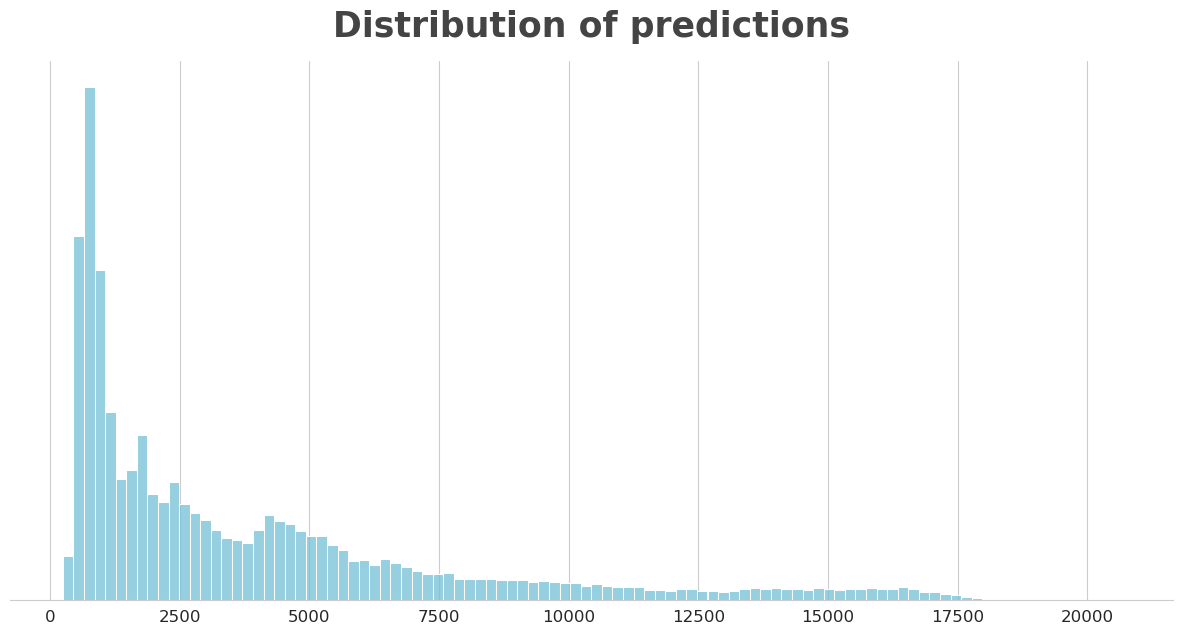

In [22]:
preds_plot(predCB)

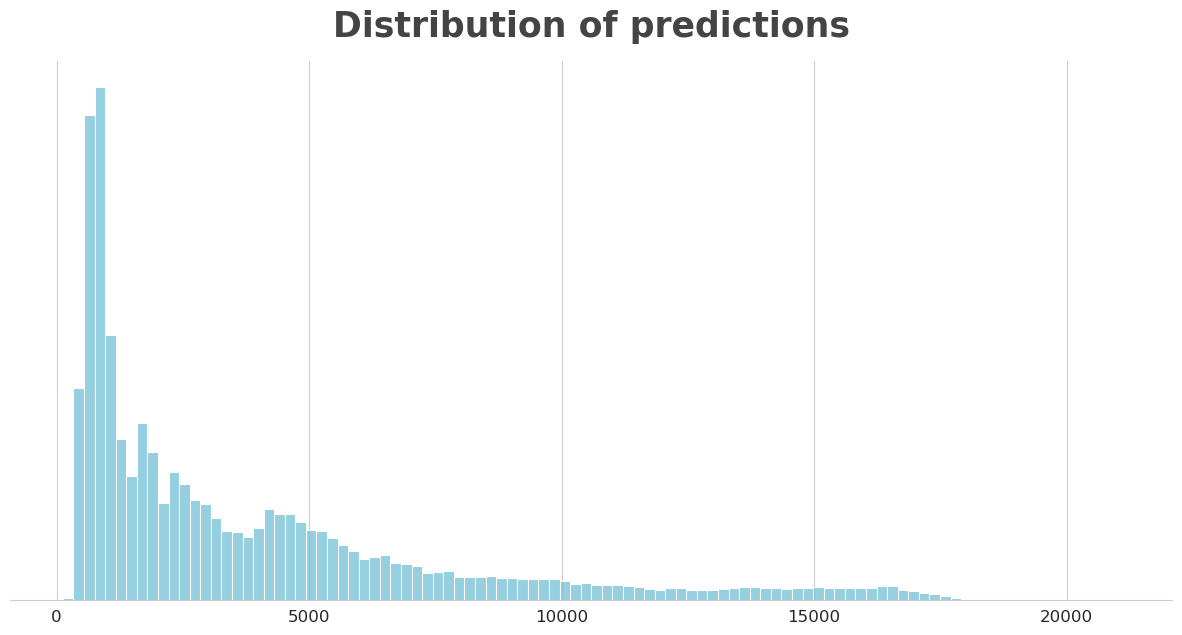

In [23]:
preds_plot(predXB)

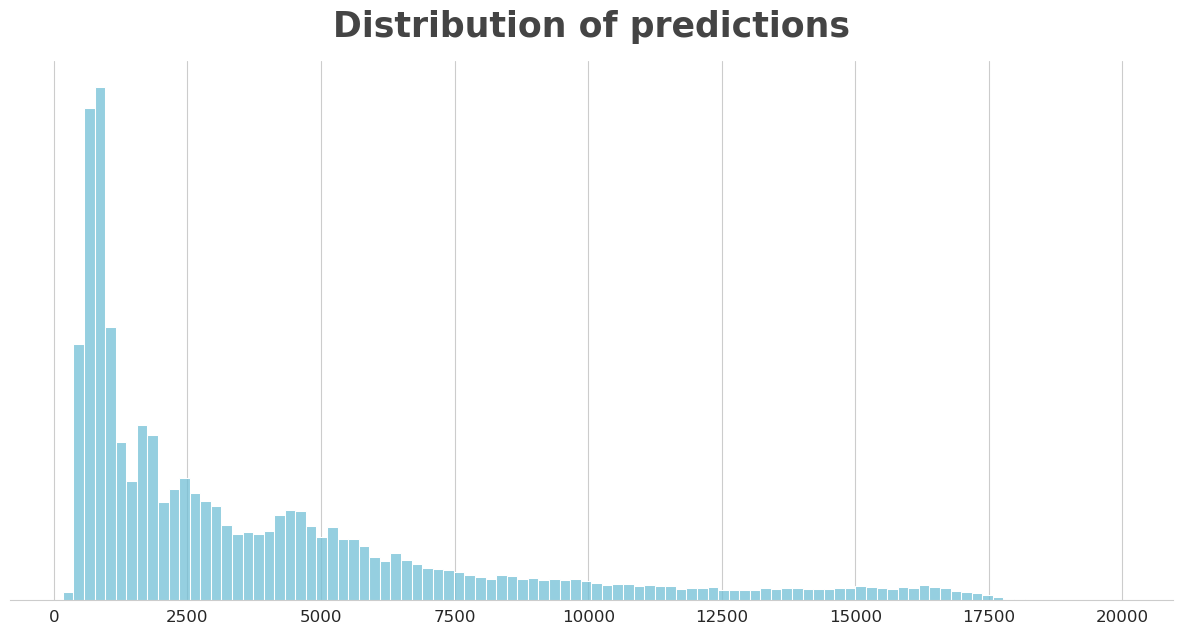

In [24]:
preds_plot(predLB)

In [25]:
pred = predCB * a + predXB * b + predLB * c #+pred_NN * d

In [26]:
submission['price'] = pred

In [27]:
submission = submission[['id','price']]

In [28]:
submission.to_csv("submission.csv",index=False)
submission

,id,price
0,193573,866.443211
1,193574,2507.481004
2,193575,2274.863164
3,193576,857.042154
4,193577,5685.579520
...,...,...
129045,322618,3994.102833
129046,322619,2597.419747
129047,322620,7862.516058
129048,322621,5802.530998
